# Инструменты для работы с языком

... или зачем нужна предобработка.

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Классификацию по тональности используют в рекомендательных системах, чтобы понять, понравилось ли людям кафе, кино, etc.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('data/positive_tweets_russian.csv', 
                       sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('data/negative_tweets_russian.csv', 
                       sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [3]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [56]:
x_train, x_test, y_train, y_test, train_idx, test_idx = \
    train_test_split(df.text, df.label, range(df.shape[0]))

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [5]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [6]:
from nltk import ngrams

In [7]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [8]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [9]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [10]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: CountVectorizer и TfidfVectorizer

Объект CountVectorizer делает очень простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности n, где n -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [11]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [12]:
list(vec.vocabulary_.items())[:10]

[('rt', 74591),
 ('petyachaykin', 68721),
 ('настроение', 164834),
 ('мне', 159438),
 ('подняла', 185548),
 ('shupova', 78073),
 ('люблю', 154791),
 ('тебя', 220946),
 ('не', 165676),
 ('могу', 159653)]

In [13]:
%%time
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

CPU times: user 28.8 s, sys: 432 ms, total: 29.2 s
Wall time: 4.97 s


In [14]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.77      0.76      0.76     28434
   positive       0.76      0.77      0.77     28275

avg / total       0.77      0.77      0.77     56709



Попробуем сделать то же самое для триграмм:

In [15]:
%%time
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.47      0.72      0.56     18243
   positive       0.82      0.61      0.70     38466

avg / total       0.71      0.65      0.66     56709

CPU times: user 24.5 s, sys: 348 ms, total: 24.8 s
Wall time: 10.2 s


(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

TfidfVectorizer делает то же, что и CountVectorizer, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

tf (term frequency) – относительная частотность слова в документе:
$$ tf(t,d) = \frac{n_{t}}{\sum_k n_{k}} $$

idf (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ idf(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

Потом просто их перемножаем:
$$tfidf_(t,d,D) = tf(t,d) \times idf(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.73      0.76      0.75     26867
   positive       0.78      0.75      0.77     29842

avg / total       0.76      0.76      0.76     56709

CPU times: user 13.5 s, sys: 224 ms, total: 13.7 s
Wall time: 4.89 s


В этот раз получилось хуже :( Вернёмся к CountVectorizer.

## Токенизация

По дефолту векторизаторы используют свои *токенизаторы*, но можно это изменить, задав аргумент `tokenizer`.

Самый наивный способ токенизировать текст -- разделить с помощью `split`. Но `split` упускает очень много всего, например, банально не отделяет пунктуацию от слов. Кроме этого, есть ещё много менее тривиальных проблем. Поэтому лучше использовать готовые токенизаторы.

In [18]:
from nltk.tokenize import word_tokenize

In [19]:
example = 'Но не каждый хочет что-то исправлять:('
word_tokenize(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

В nltk вообще есть довольно много токенизаторов:

In [20]:
from nltk import tokenize
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'PunktSentenceTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer',
 'TreebankWordTokenizer',
 'TweetTokenizer',
 'WhitespaceTokenizer',
 'WordPunctTokenizer']

Они умеют выдавать индексы начала и конца каждого токена:

In [21]:
wh_tok = tokenize.WhitespaceTokenizer()
list(wh_tok.span_tokenize(example))

[(0, 2), (3, 5), (6, 12), (13, 18), (19, 25), (26, 38)]

(если вам было интересно, зачем вообще включать в модуль токенизатор, который работает как `.split()` :))

Некторые токенизаторы ведут себя специфично:

In [22]:
tokenize.TreebankWordTokenizer().tokenize("don't stop me")

['do', "n't", 'stop', 'me']

Для некоторых задач это может быть полезно.

А некоторые -- вообще не для текста на естественном языке (не очень понятно, зачем это в nltk :)):

In [23]:
tokenize.SExprTokenizer().tokenize("(a (b c)) d e (f)")

['(a (b c))', 'd', 'e', '(f)']

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [24]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [25]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [27]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.80      0.76      0.78     29468
   positive       0.76      0.80      0.78     27241

avg / total       0.78      0.78      0.78     56709

CPU times: user 50.1 s, sys: 268 ms, total: 50.4 s
Wall time: 35.8 s


Получилось чуть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [28]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [29]:
print(mystem_analyzer.lemmatize(example))

['но', ' ', 'не', ' ', 'каждый', ' ', 'хотеть', ' ', 'что-то', ' ', 'исправлять', ':(\n']


А можно получить грамматическую информацию:

In [30]:
mystem_analyzer.analyze(example)

[{'analysis': [{'lex': 'но', 'wt': 0.9998906299, 'gr': 'CONJ='}],
  'text': 'Но'},
 {'text': ' '},
 {'analysis': [{'lex': 'не', 'wt': 1, 'gr': 'PART='}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'lex': 'каждый',
    'wt': 0.9985975799,
    'gr': 'APRO=(вин,ед,муж,неод|им,ед,муж)'}],
  'text': 'каждый'},
 {'text': ' '},
 {'analysis': [{'lex': 'хотеть',
    'wt': 1,
    'gr': 'V,несов,пе=непрош,ед,изъяв,3-л'}],
  'text': 'хочет'},
 {'text': ' '},
 {'analysis': [{'lex': 'что-то', 'wt': 1, 'gr': 'SPRO,ед,сред,неод=(вин|им)'}],
  'text': 'что-то'},
 {'text': ' '},
 {'analysis': [{'lex': 'исправлять', 'wt': 1, 'gr': 'V,пе=инф,несов'}],
  'text': 'исправлять'},
 {'text': ':(\n'}]

Давайте терепь лемматизатор майстема в качестве токенизатора.

In [31]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [32]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)

CPU times: user 4min 44s, sys: 26.6 s, total: 5min 11s
Wall time: 6min 26s


In [33]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.78      0.74      0.76     29286
   positive       0.74      0.77      0.75     27423

avg / total       0.76      0.76      0.76     56709



### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [34]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [35]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'платили', 2368, 10),))]

In [36]:
ana[0].normal_form

'платить'

А теперь напишите аналогичную функцию для лемматизации с pymorphy2:

In [37]:
def my_preproc_pymorphy(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = [pymorphy2_analyzer.parse(w)[0].normal_form for w in text.split()
            if w not in stopwords.words('russian') + [' ', '\n']]
    return text

In [38]:
example

'Но не каждый хочет что-то исправлять:('

In [39]:
my_preproc_pymorphy(example)

['но', 'каждый', 'хотеть', 'чтоть', 'исправлять']

Что будет, если использовать её в качестве препроцессора? 

In [40]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc_pymorphy)
bow = vec.fit_transform(x_train)

CPU times: user 5min 16s, sys: 13.4 s, total: 5min 29s
Wall time: 5min 29s


In [41]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.78      0.74      0.76     29369
   positive       0.73      0.77      0.75     27340

avg / total       0.76      0.75      0.75     56709



### mystem vs. pymorphy

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту:

In [42]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292664, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970041, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [43]:
from collections import Counter

In [44]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) 
          if token not in punctuation]
print(len(corpus))
corpus[:10]

2859146


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [45]:
freq_dict = Counter(corpus)
freq_dict_sorted = sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69267),
 ('и', 54916),
 ('в', 52853),
 ('я', 52506),
 ('RT', 38070),
 ('на', 35715),
 ('http', 32992),
 ('что', 31472),
 ('...', 28773),
 ('с', 27176)]

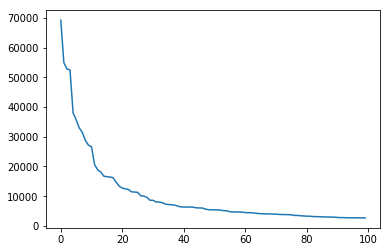

In [54]:
import matplotlib.pyplot as plt
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs);

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [47]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       1.00      1.00      1.00     27951
   positive       1.00      1.00      1.00     28758

avg / total       1.00      1.00      1.00     56709

CPU times: user 41 s, sys: 103 ms, total: 41.1 s
Wall time: 35 s


Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

In [48]:
inv_voc = {v: k for (k, v) in vec.vocabulary_.items()}

Most negative

In [49]:
[inv_voc[i] for i in np.argsort(clf.coef_)[:, :10].tolist()[0]]

['(',
 '|',
 'о_о',
 'o_o',
 '-/',
 'cio_optimal',
 'to_over_kill',
 'do_or_die_xxx',
 'prisonero_o',
 'rt']

Most positive

In [50]:
[inv_voc[i] for i in np.argsort(clf.coef_)[:, -10:].tolist()[0][::-1]]

[')', 'd', '*', 'dd', '^_^', 'ddd', '-d', '**', ':', 'dddd']

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [51]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       1.00      0.85      0.92     32966
   positive       0.83      1.00      0.90     23743

avg / total       0.93      0.91      0.91     56709



## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [52]:
%%time
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.99      1.00      0.99     27861
   positive       1.00      0.99      1.00     28848

avg / total       0.99      0.99      0.99     56709

CPU times: user 11 s, sys: 44.5 ms, total: 11 s
Wall time: 10 s


В общем-то, теперь уже понятно, почему на этих данных здесь 1. Просто знайте, что так можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

## fastText

https://fasttext.cc/docs/en/supervised-tutorial.html

Если осталось время -- сами поизучайте этот модуль и попробуйти применить его к нашей задаче.

In [55]:
from fastText import train_supervised

Preprocessing for FastText

In [68]:
def fasttext_preprocess(df, out_file):
    df['label'] = df['label'].apply(lambda l: '__label__' + str(l))
    df[['label', 'text']].to_csv(out_file, index=None, header=None, sep=' ')

In [70]:
fasttext_preprocess(df.iloc[train_idx, :], 'data/tweets_russian_train.csv')
fasttext_preprocess(df.iloc[test_idx, :], 'data/tweets_russian_test.csv')

/home/yorko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [71]:
!head data/tweets_russian_train.csv

__label__negative "аа да ну збс теперь  укольчики прописали пипец , болючие зараза("
__label__positive "фото) и тем кто лайкнет этот же вопрос:) — вот) http://t.co/4xKzMToHto"
__label__positive "Капец...вспомнила как с девочками делали сникерс на технологии:D"
__label__positive "@rutkovskaya_tan о боже,ты знаешь почти всё про меня:Dвсё самое не приличное ахаха"
__label__negative "#вынеповерите #убейтеменя #какямог Я удалила #nyan #cat :С Заебало :("
__label__negative "А тем временем в США... не то, что у нас =( http://t.co/EhcdTnJTvO"
__label__negative "У него слишком заметная внешность. =( #ff #follow"
__label__positive "@Imichko @Svetonos блин им там не холодно целыми днями стоять то?))"
__label__negative "@DeerofMirkwood я вот понимаю, что я ёлку хотела к 25 поставить, но не успею... столько по универу делать надо( прям печаль."
__label__positive "Зная себя, я бы постепенно просаживала их в макдаке - то есть платила бы за прыщи и кг)) Ничуть не лучше си"


In [72]:
model = train_supervised(
        input='data/tweets_russian_train.csv', epoch=25, lr=1.0, wordNgrams=2, 
    verbose=2, minCount=1)

In [73]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [74]:
print_results(*model.test('data/tweets_russian_test.csv'))

N	56709
P@1	0.826
R@1	0.826
